In [1]:
import os
import requests
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Create a data directory
data_dir = Path("./data")
data_dir.mkdir(exist_ok=True)

In [2]:
# Zenodo record URL
zenodo_record = "10054101"
api_url = f"https://zenodo.org/api/records/{zenodo_record}"

print("Fetching file information from Zenodo...")
response = requests.get(api_url)
record_data = response.json()

# List available files
for file_info in record_data['files']:
    print(f"Filename: {file_info['key']}")
    print(f"Size: {file_info['size'] / 1e6:.2f} MB")
    print(f"Download URL: {file_info['links']['self']}")
    print("-"*60)

# Download the data files
print("\nDownloading files...")
downloaded_files = []
for file_info in record_data['files']:
    filename = file_info['key']
    download_url = file_info['links']['self']
    filepath = data_dir / filename
    
    # Skip if already downloaded
    if filepath.exists():
        print(f"File {filename} already exists, skipping download.")
        downloaded_files.append(filepath)
        continue
    
    print(f"Downloading {filename}...")
    file_response = requests.get(download_url, stream=True)
    file_response.raise_for_status()
    
    with open(filepath, 'wb') as f:
        for chunk in file_response.iter_content(chunk_size=8192):
            f.write(chunk)
    
    downloaded_files.append(filepath)
    print(f"Downloaded {filename} ({file_info['size'] / 1e6:.2f} MB)")

Fetching file information from Zenodo...
Filename: test_arr.npz
Size: 180.47 MB
Download URL: https://zenodo.org/api/records/10054101/files/test_arr.npz/content
------------------------------------------------------------
Filename: train_arr.npz
Size: 1097.93 MB
Download URL: https://zenodo.org/api/records/10054101/files/train_arr.npz/content
------------------------------------------------------------

File test_arr.npz already exists, skipping download.
File train_arr.npz already exists, skipping download.


In [3]:
files = list(data_dir.glob("*.npz"))
files

[PosixPath('data/test_arr.npz'), PosixPath('data/train_arr.npz')]

In [4]:
test_data = np.load(files[0]) # only the test data bc it's smaller

print(f"\nKeys in .npz file: {list(test_data.keys())}")
data_array = test_data['data'] # shape (time, features, ensemble, ics)
mask_array = test_data['mask'] # same shape as data_array

print(f"\ndata shape: {data_array.shape}")
print(f"mask shape: {mask_array.shape}")
print(f"\ndata dtype: {data_array.dtype}")
print(f"mask dtype: {mask_array.dtype}")

n_time, n_features, n_ensemble, n_ics = data_array.shape

# apply the mask
test_data_masked = np.ma.MaskedArray(data_array, mask=mask_array)

print("\nAfter masking:")
print(f"Min: {test_data_masked.min()}")
print(f"Max: {test_data_masked.max()}")  
print(f"Mean: {test_data_masked.mean()}")


Keys in .npz file: ['data', 'mask']

data shape: (3599, 18, 100, 100)
mask shape: (3599, 18, 100, 100)

data dtype: float32
mask dtype: bool

After masking:
Min: 0.0
Max: 654438016.0
Mean: 3081281.8575927634


In [5]:
# Trajectory lengths per IC
traj_lengths = []
for ic_idx in range(min(10, test_data_masked.shape[2])):
    # Find last valid timestep for this IC (check first realization, first real feature)
    valid_times = ~test_data_masked[:, 0, ic_idx, 0].mask
    n_valid = valid_times.sum()
    traj_lengths.append(n_valid)
    print(f"IC {ic_idx}: {n_valid} valid timesteps ({n_valid * 20} seconds)")

print(f"Min: {min(traj_lengths)} timesteps")
print(f"Max: {max(traj_lengths)} timesteps")

IC 0: 130 valid timesteps (2600 seconds)
IC 1: 779 valid timesteps (15580 seconds)
IC 2: 324 valid timesteps (6480 seconds)
IC 3: 149 valid timesteps (2980 seconds)
IC 4: 59 valid timesteps (1180 seconds)
IC 5: 359 valid timesteps (7180 seconds)
IC 6: 449 valid timesteps (8980 seconds)
IC 7: 124 valid timesteps (2480 seconds)
IC 8: 174 valid timesteps (3480 seconds)
IC 9: 239 valid timesteps (4780 seconds)
Min: 59 timesteps
Max: 779 timesteps


In [6]:
# Check initial conditions across ICs (features 14, 15, 16)...
for ic_idx in range(5):
    ic_params = test_data_masked[0, 14:17, ic_idx, 0].data
    print(f"IC {ic_idx}: q_w0={ic_params[0]:.4e}, r_0={ic_params[1]:.4e}, ν={ic_params[2]:.1f}")

IC 0: q_w0=1.6000e-03, r_0=1.2000e-05, ν=4.0
IC 1: q_w0=5.0000e-04, r_0=1.0000e-05, ν=3.0
IC 2: q_w0=1.2000e-03, r_0=1.0000e-05, ν=2.5
IC 3: q_w0=1.0000e-03, r_0=1.4000e-05, ν=3.0
IC 4: q_w0=2.0000e-03, r_0=1.5000e-05, ν=1.0


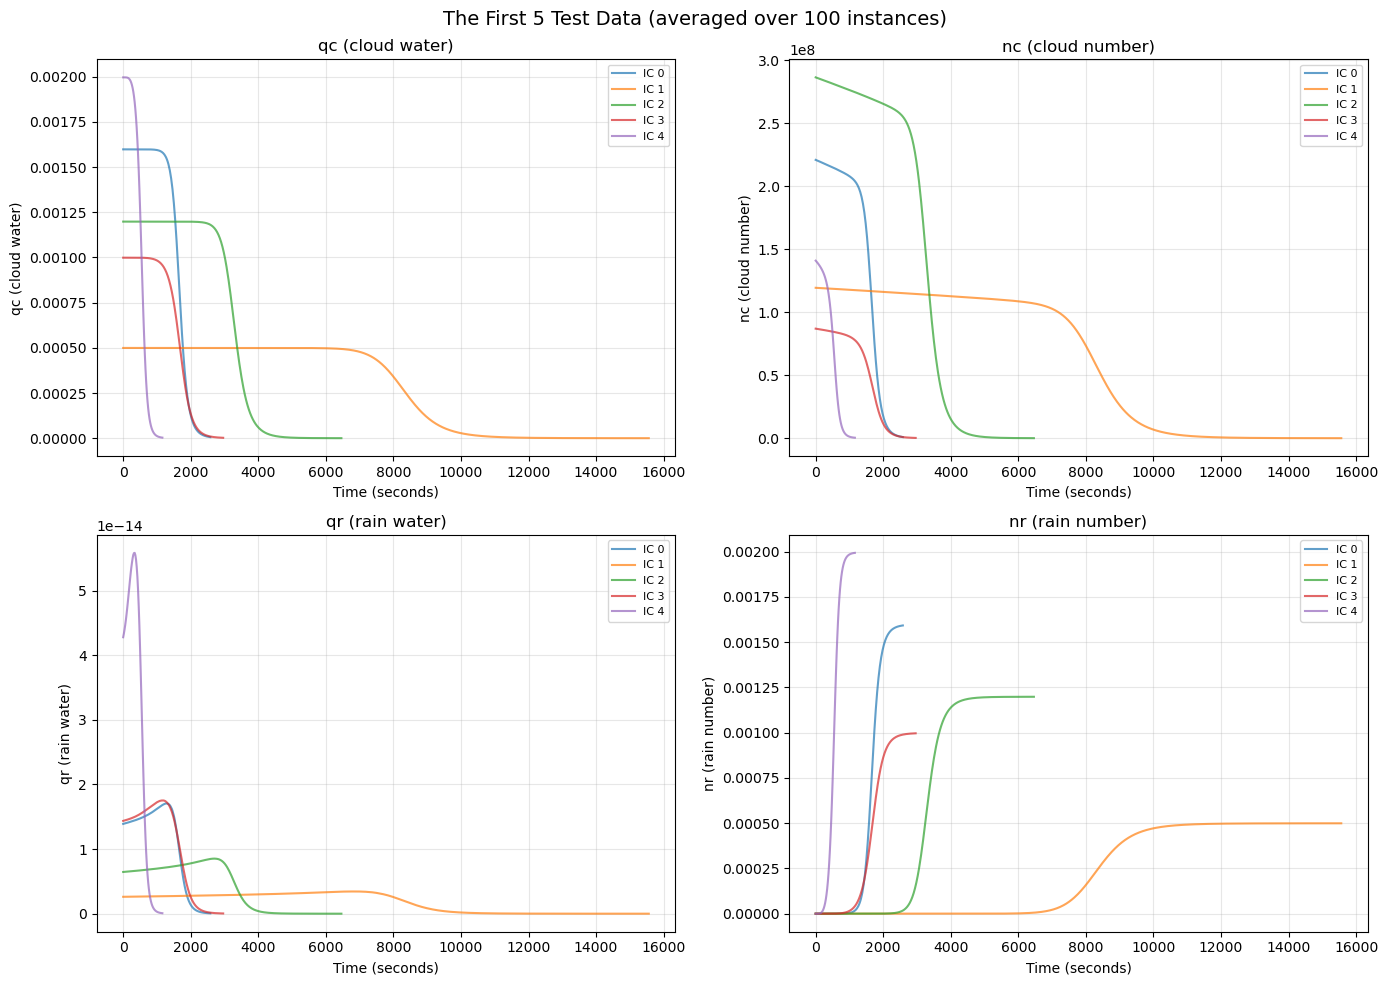

In [7]:
# Visualize a few trajectories
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
moment_names = ['qc (cloud water)', 'nc (cloud number)', 
                'qr (rain water)', 'nr (rain number)']
moment_indices = [1, 2, 3, 4]  # Features 1-4 are the 4 bulk moments

for i, (ax, name, feat_idx) in enumerate(zip(axes.flat, moment_names, moment_indices)):
    for ic in range(5):  # Plot 5 ICs
        # Average over realizations (axis 3)
        trajectory = test_data_masked[:, feat_idx, ic, :].mean(axis=1)
        
        # Get valid timesteps
        valid = ~trajectory.mask
        n_valid = valid.sum()
        time_steps = np.arange(n_valid) * 20  # 20s intervals
        
        ax.plot(time_steps, trajectory.compressed(), alpha=0.7, label=f'IC {ic}', linewidth=1.5)
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel(name)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_title(name)

plt.suptitle('The First 5 Test Data (averaged over 100 instances)', fontsize=14)
plt.tight_layout()
plt.savefig('test_trajectories_exploration.png', dpi=150, bbox_inches='tight')

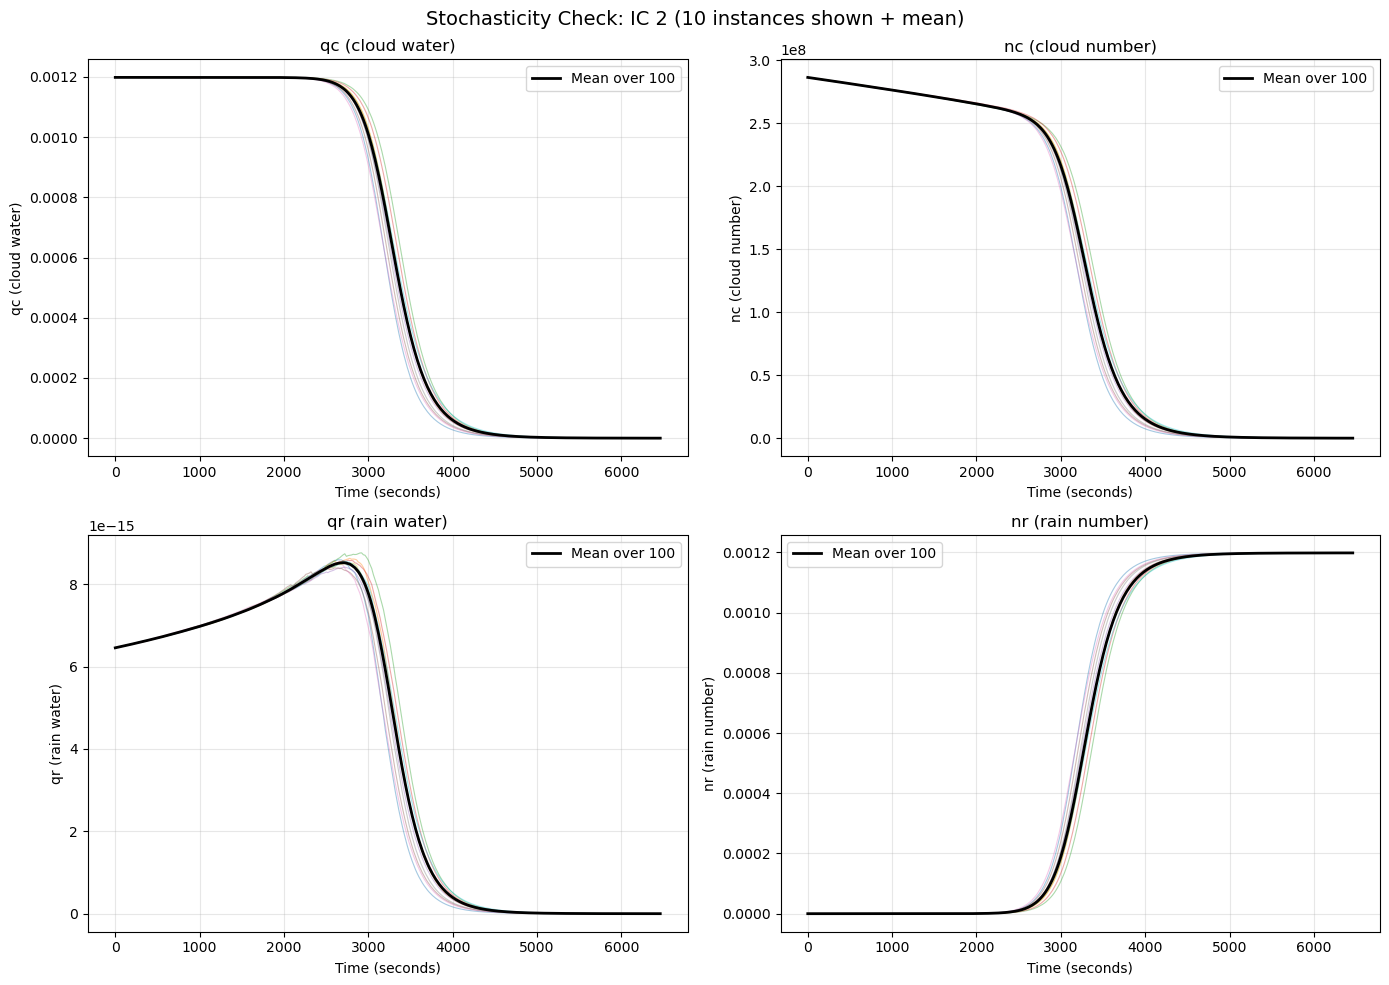

In [8]:
# Check variation across realizations for one IC
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ic_to_plot = 2  # Look at third IC

for i, (ax, name, feat_idx) in enumerate(zip(axes.flat, moment_names, moment_indices)):
    # Plot individual realizations (not averaged)
    for real in range(10):  # Plot 10 out of 100 realizations
        trajectory = test_data_masked[:, feat_idx, ic_to_plot, real]
        valid = ~trajectory.mask
        n_valid = valid.sum()
        time_steps = np.arange(n_valid) * 20
        ax.plot(time_steps, trajectory.compressed(), alpha=0.4, linewidth=0.8)
    
    # Also plot the mean
    trajectory_mean = test_data_masked[:, feat_idx, ic_to_plot, :].mean(axis=1)
    valid = ~trajectory_mean.mask
    n_valid = valid.sum()
    time_steps = np.arange(n_valid) * 20
    ax.plot(time_steps, trajectory_mean.compressed(), 'k-', linewidth=2, label='Mean over 100')
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel(name)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_title(name)

plt.suptitle(f'Stochasticity Check: IC {ic_to_plot} (10 instances shown + mean)', fontsize=14)
plt.tight_layout()
plt.savefig('test_stochasticity_check.png', dpi=150, bbox_inches='tight')